In [1]:
# ANÁLISIS EXPLORATORIO DE DATOS - NECROPSIAS GUATEMALA (INE)
# Universidad del Valle de Guatemala - CC3074 Minería de Datos

## 1. CONFIGURACIÓN INICIAL

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat
import warnings
import os
import re
from scipy import stats
from scipy.stats import shapiro, normaltest, chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import glob

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

os.makedirs('resultados', exist_ok=True)
os.makedirs('graficos', exist_ok=True)

print(" Librerías cargadas exitosamente")

 Librerías cargadas exitosamente


## 2. CARGA Y UNIÓN DE DATOS

In [3]:
# Usar directorio actual
ruta_datos = "."

archivos = glob.glob(os.path.join(ruta_datos, "necropsias*.sav"))
print(f"\n Archivos encontrados: {len(archivos)}")
for archivo in sorted(archivos):
    print(f"   - {os.path.basename(archivo)}")


 Archivos encontrados: 11
   - necropsias2011.sav
   - necropsias2012.sav
   - necropsias2016.sav
   - necropsias2017.sav
   - necropsias2018.sav
   - necropsias2019.sav
   - necropsias2020.sav
   - necropsias2021.sav
   - necropsias2022.sav
   - necropsias2023.sav
   - necropsias2024.sav


In [4]:
def cargar_necropsia(archivo):
    """Carga un archivo .sav de necropsias y agrega columna de año"""
    nombre_archivo = os.path.basename(archivo)
    anio = re.search(r'(\d{4})', nombre_archivo)
    
    if anio:
        anio = int(anio.group(1))
    else:
        print(f"No se pudo extraer el año de: {nombre_archivo}")
        return None
    
    try:
        df, meta = pyreadstat.read_sav(archivo)
        df['anio'] = anio
        print(f"{nombre_archivo}: {len(df)} registros")
        return df
    except Exception as e:
        print(f"Error al cargar {nombre_archivo}: {str(e)}")
        return None

lista_dataframes = []
for archivo in sorted(archivos):
    df = cargar_necropsia(archivo)
    if df is not None:
        lista_dataframes.append(df)

print("\n Uniendo todos los datasets...")
necropsias = pd.concat(lista_dataframes, ignore_index=True, sort=False)

print(f" DATOS CARGADOS EXITOSAMENTE")
print(f"\n Total de registros: {len(necropsias):,}")
print(f" Total de variables: {len(necropsias.columns)}")
print(f" Años disponibles: {sorted(necropsias['anio'].unique())}")

necropsias2011.sav: 13137 registros
necropsias2012.sav: 12753 registros
necropsias2016.sav: 12179 registros
necropsias2017.sav: 11848 registros
necropsias2018.sav: 11512 registros
necropsias2019.sav: 11351 registros
necropsias2020.sav: 8819 registros
necropsias2021.sav: 10281 registros
necropsias2022.sav: 10729 registros
necropsias2023.sav: 11038 registros
necropsias2024.sav: 2598 registros

 Uniendo todos los datasets...
 DATOS CARGADOS EXITOSAMENTE

 Total de registros: 116,245
 Total de variables: 31
 Años disponibles: [np.int64(2011), np.int64(2012), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


## 3. LIMPIEZA Y CONSOLIDACIÓN DE DATOS

Los archivos de diferentes años tienen nombres de variables ligeramente distintos.
Consolidamos las variables duplicadas para tener un dataset uniforme.

In [5]:
print("3. LIMPIEZA Y CONSOLIDACIÓN DE DATOS")

# 3.1 Consolidar variables de EDAD
print("\n Consolidando variable EDAD...")
necropsias['edad'] = necropsias['edad_per'].fillna(necropsias['edad_person'])
# Limpiar valores inválidos (999 = desconocido según INE)
necropsias.loc[necropsias['edad'] >= 999, 'edad'] = np.nan
print(f"    edad: {necropsias['edad'].notna().sum():,} valores válidos")

# 3.2 Consolidar variables de SEXO
print("\n Consolidando variable SEXO...")
necropsias['sexo'] = necropsias['sexo_per'].fillna(
    necropsias['sexo_person'].fillna(necropsias['sexo_per_eva'])
)
# Codificar: 1=Hombre, 2=Mujer, 9=No especificado
necropsias.loc[necropsias['sexo'] == 9, 'sexo'] = np.nan
print(f"    sexo: {necropsias['sexo'].notna().sum():,} valores válidos")

# 3.3 Consolidar MES de ocurrencia
print("\n Consolidando variable MES...")
necropsias['mes'] = necropsias['mes_ocu'].fillna(necropsias['mes_ing'])
print(f"    mes: {necropsias['mes'].notna().sum():,} valores válidos")

# 3.4 Consolidar DÍA DE LA SEMANA
print("\n Consolidando variable DÍA DE LA SEMANA...")
necropsias['dia_semana'] = necropsias['diasem_ocu'].fillna(
    necropsias['día_sem_ocu'].fillna(necropsias['dia_sem_ocu'])
)
print(f"    dia_semana: {necropsias['dia_semana'].notna().sum():,} valores válidos")

# 3.5 Consolidar CAUSA DE MUERTE
print("\n Consolidando variable CAUSA DE MUERTE...")
necropsias['causa'] = necropsias['causa_muerte'].fillna(necropsias['eva_mn'])
print(f"    causa: {necropsias['causa'].notna().sum():,} valores válidos")

# 3.6 Consolidar MUNICIPIO
print("\n Consolidando variable MUNICIPIO...")
necropsias['municipio'] = necropsias['mupio_ocu']
print(f"    municipio: {necropsias['municipio'].notna().sum():,} valores válidos")

# 3.7 Consolidar DEPARTAMENTO
necropsias['departamento'] = necropsias['depto_ocu']

# Crear dataset limpio con variables consolidadas
vars_limpias = ['anio', 'mes', 'dia_semana', 'departamento', 'municipio', 
                'edad', 'sexo', 'causa']
df_limpio = necropsias[vars_limpias].copy()

print(f"\n Dataset limpio creado con {len(vars_limpias)} variables consolidadas")
print(f" Registros totales: {len(df_limpio):,}")

# Resumen de valores faltantes después de limpieza
print("\n Valores faltantes después de consolidación:")
for col in vars_limpias:
    faltantes = df_limpio[col].isna().sum()
    pct = faltantes / len(df_limpio) * 100
    print(f"   {col:15s}: {faltantes:,} ({pct:.1f}%)")

3. LIMPIEZA Y CONSOLIDACIÓN DE DATOS

 Consolidando variable EDAD...
    edad: 114,692 valores válidos

 Consolidando variable SEXO...
    sexo: 115,286 valores válidos

 Consolidando variable MES...
    mes: 116,245 valores válidos

 Consolidando variable DÍA DE LA SEMANA...
    dia_semana: 46,890 valores válidos

 Consolidando variable CAUSA DE MUERTE...
    causa: 116,245 valores válidos

 Consolidando variable MUNICIPIO...
    municipio: 78,176 valores válidos

 Dataset limpio creado con 8 variables consolidadas
 Registros totales: 116,245

 Valores faltantes después de consolidación:
   anio           : 0 (0.0%)
   mes            : 0 (0.0%)
   dia_semana     : 69,355 (59.7%)
   departamento   : 0 (0.0%)
   municipio      : 38,069 (32.7%)
   edad           : 1,553 (1.3%)
   sexo           : 959 (0.8%)
   causa          : 0 (0.0%)


## 4. DESCRIPCIÓN DEL DATASET

In [6]:
print("4. DESCRIPCIÓN DEL DATASET")

print(f"\n Dimensiones del dataset limpio:")
print(f"   - Observaciones (filas): {df_limpio.shape[0]:,}")
print(f"   - Variables (columnas): {df_limpio.shape[1]}")

print(f"\n Variables y tipos:")
for col in df_limpio.columns:
    tipo = str(df_limpio[col].dtype)
    no_nulos = df_limpio[col].notna().sum()
    print(f"   {col:15s} | {tipo:10s} | {no_nulos:,} valores")

4. DESCRIPCIÓN DEL DATASET

 Dimensiones del dataset limpio:
   - Observaciones (filas): 116,245
   - Variables (columnas): 8

 Variables y tipos:
   anio            | int64      | 116,245 valores
   mes             | float64    | 116,245 valores
   dia_semana      | float64    | 46,890 valores
   departamento    | float64    | 116,245 valores
   municipio       | float64    | 78,176 valores
   edad            | float64    | 114,692 valores
   sexo            | float64    | 115,286 valores
   causa           | float64    | 116,245 valores


In [7]:
# Estadísticas descriptivas
print("\n Estadísticas descriptivas:")
print(df_limpio.describe())

# Guardar
df_limpio.describe().to_csv('resultados/estadisticas_descriptivas.csv')


 Estadísticas descriptivas:
                anio            mes    dia_semana   departamento  \
count  116245.000000  116245.000000  46890.000000  116245.000000   
mean     2017.731971       6.444380      4.118810       7.750914   
std         3.973489       3.508789      2.088353       7.211122   
min      2011.000000       1.000000      1.000000       1.000000   
25%      2016.000000       3.000000      2.000000       1.000000   
50%      2018.000000       6.000000      4.000000       5.000000   
75%      2021.000000      10.000000      6.000000      14.000000   
max      2024.000000      12.000000      7.000000      99.000000   

          municipio           edad           sexo          causa  
count  78176.000000  114692.000000  115286.000000  116245.000000  
mean     795.524048      35.006766       1.174488      19.291247  
std      719.766829      18.124620       0.379530      13.435863  
min      101.000000       0.000000       1.000000       1.000000  
25%      108.000000    

## 5. ANÁLISIS DE VARIABLES NUMÉRICAS

In [9]:
print("="*80)
print("5. ANÁLISIS DE VARIABLES NUMÉRICAS")
print("="*80)

# 5.1 EDAD - Análisis detallado
print("\n 5.1 Análisis de EDAD")
edad_valida = df_limpio['edad'].dropna()
print(f"   N válido: {len(edad_valida):,}")
print(f"   Media: {edad_valida.mean():.2f} años")
print(f"   Mediana: {edad_valida.median():.2f} años")
print(f"   Desv. Est.: {edad_valida.std():.2f}")
print(f"   Mínimo: {edad_valida.min():.0f}")
print(f"   Máximo: {edad_valida.max():.0f}")
print(f"   Asimetría: {edad_valida.skew():.3f}")
print(f"   Curtosis: {edad_valida.kurtosis():.3f}")

# Prueba de normalidad D'Agostino-Pearson (para muestras grandes)
if len(edad_valida) > 8:
    stat, p_value = normaltest(edad_valida.sample(min(5000, len(edad_valida))))
    print(f"\n   Test D'Agostino-Pearson:")
    print(f"   Estadístico: {stat:.4f}, p-value: {p_value:.6f}")
    print(f"   {' NO sigue distribución normal' if p_value < 0.05 else ' Sigue distribución normal'}")

5. ANÁLISIS DE VARIABLES NUMÉRICAS

 5.1 Análisis de EDAD
   N válido: 114,692
   Media: 35.01 años
   Mediana: 31.00 años
   Desv. Est.: 18.12
   Mínimo: 0
   Máximo: 100
   Asimetría: 0.665
   Curtosis: 0.251

   Test D'Agostino-Pearson:
   Estadístico: 307.6689, p-value: 0.000000
    NO sigue distribución normal


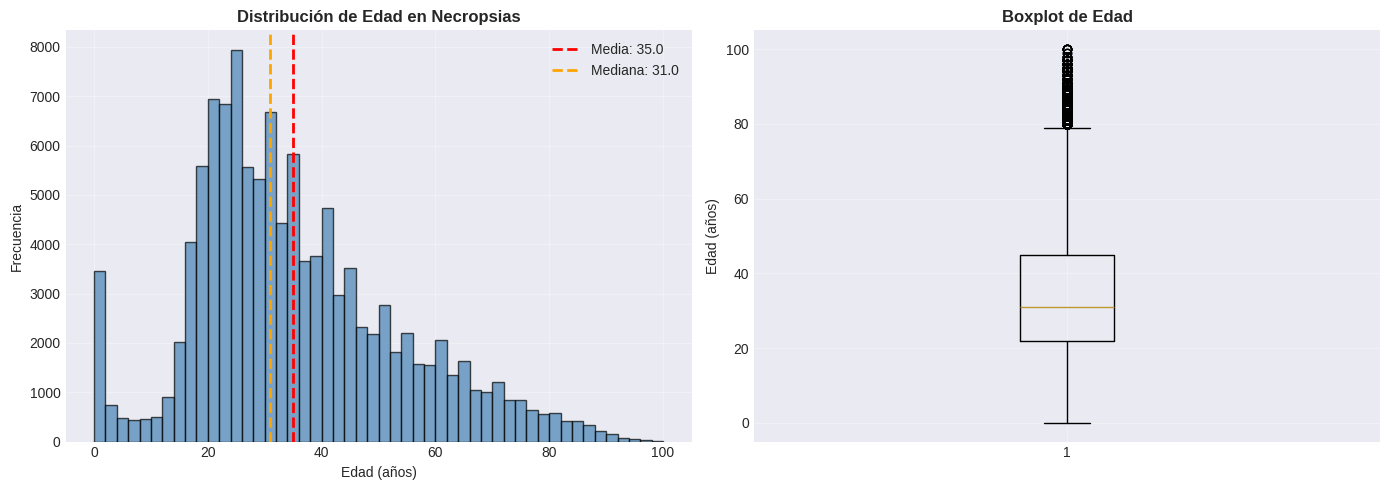

In [10]:
# Histograma de edad
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(edad_valida, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(edad_valida.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {edad_valida.mean():.1f}')
axes[0].axvline(edad_valida.median(), color='orange', linestyle='--', linewidth=2, label=f'Mediana: {edad_valida.median():.1f}')
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Edad en Necropsias', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(edad_valida, vert=True)
axes[1].set_ylabel('Edad (años)')
axes[1].set_title('Boxplot de Edad', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graficos/edad_distribucion.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. ANÁLISIS DE VARIABLES CATEGÓRICAS

In [11]:
print("="*80)
print("6. ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*80)

# 6.1 SEXO
print("\n 6.1 Distribución por SEXO")
sexo_map = {1: 'Hombre', 2: 'Mujer'}
df_limpio['sexo_nombre'] = df_limpio['sexo'].map(sexo_map)
sexo_freq = df_limpio['sexo_nombre'].value_counts()
sexo_pct = df_limpio['sexo_nombre'].value_counts(normalize=True) * 100

print("\n   Tabla de frecuencias:")
for cat in sexo_freq.index:
    print(f"   {cat:10s}: {sexo_freq[cat]:,} ({sexo_pct[cat]:.1f}%)")

6. ANÁLISIS DE VARIABLES CATEGÓRICAS

 6.1 Distribución por SEXO

   Tabla de frecuencias:
   Hombre    : 95,170 (82.6%)
   Mujer     : 20,116 (17.4%)


In [12]:
# 6.2 DEPARTAMENTO
print("\n 6.2 Distribución por DEPARTAMENTO")

# Diccionario de departamentos de Guatemala
deptos_gt = {
    1: 'Guatemala', 2: 'El Progreso', 3: 'Sacatepéquez', 4: 'Chimaltenango',
    5: 'Escuintla', 6: 'Santa Rosa', 7: 'Sololá', 8: 'Totonicapán',
    9: 'Quetzaltenango', 10: 'Suchitepéquez', 11: 'Retalhuleu', 12: 'San Marcos',
    13: 'Huehuetenango', 14: 'Quiché', 15: 'Baja Verapaz', 16: 'Alta Verapaz',
    17: 'Petén', 18: 'Izabal', 19: 'Zacapa', 20: 'Chiquimula',
    21: 'Jalapa', 22: 'Jutiapa'
}

df_limpio['depto_nombre'] = df_limpio['departamento'].map(deptos_gt)
depto_freq = df_limpio['depto_nombre'].value_counts()
print("\n   Top 10 departamentos:")
for i, (depto, count) in enumerate(depto_freq.head(10).items(), 1):
    pct = count / len(df_limpio) * 100
    print(f"   {i:2d}. {depto:20s}: {count:,} ({pct:.1f}%)")


 6.2 Distribución por DEPARTAMENTO

   Top 10 departamentos:
    1. Guatemala           : 44,009 (37.9%)
    2. Escuintla           : 11,272 (9.7%)
    3. Quetzaltenango      : 5,621 (4.8%)
    4. Petén               : 5,291 (4.6%)
    5. Chiquimula          : 4,703 (4.0%)
    6. Izabal              : 4,610 (4.0%)
    7. Santa Rosa          : 4,403 (3.8%)
    8. Alta Verapaz        : 3,756 (3.2%)
    9. Jutiapa             : 3,614 (3.1%)
   10. Suchitepéquez       : 3,409 (2.9%)


In [13]:
# 6.3 CAUSA DE MUERTE
print("\n 6.3 Distribución por CAUSA DE MUERTE")

# Códigos simplificados de causa (según clasificación INE)
causas_map = {
    1: 'Arma de fuego', 2: 'Arma blanca', 3: 'Estrangulación', 
    4: 'Trauma contundente', 5: 'Caída', 6: 'Ahogamiento',
    20: 'Accidente tránsito', 37: 'Causa natural', 43: 'Otra/Desconocida'
}

causa_freq = df_limpio['causa'].value_counts().head(10)
print("\n   Top 10 causas de muerte:")
for i, (causa, count) in enumerate(causa_freq.items(), 1):
    nombre = causas_map.get(int(causa), f'Código {int(causa)}')
    pct = count / df_limpio['causa'].notna().sum() * 100
    print(f"   {i:2d}. {nombre:25s}: {count:,} ({pct:.1f}%)")


 6.3 Distribución por CAUSA DE MUERTE

   Top 10 causas de muerte:
    1. Causa natural            : 29,741 (25.6%)
    2. Accidente tránsito       : 26,055 (22.4%)
    3. Arma blanca              : 16,483 (14.2%)
    4. Arma de fuego            : 10,333 (8.9%)
    5. Ahogamiento              : 5,478 (4.7%)
    6. Código 21                : 5,410 (4.7%)
    7. Código 19                : 3,334 (2.9%)
    8. Código 27                : 2,724 (2.3%)
    9. Código 22                : 2,258 (1.9%)
   10. Estrangulación           : 2,231 (1.9%)


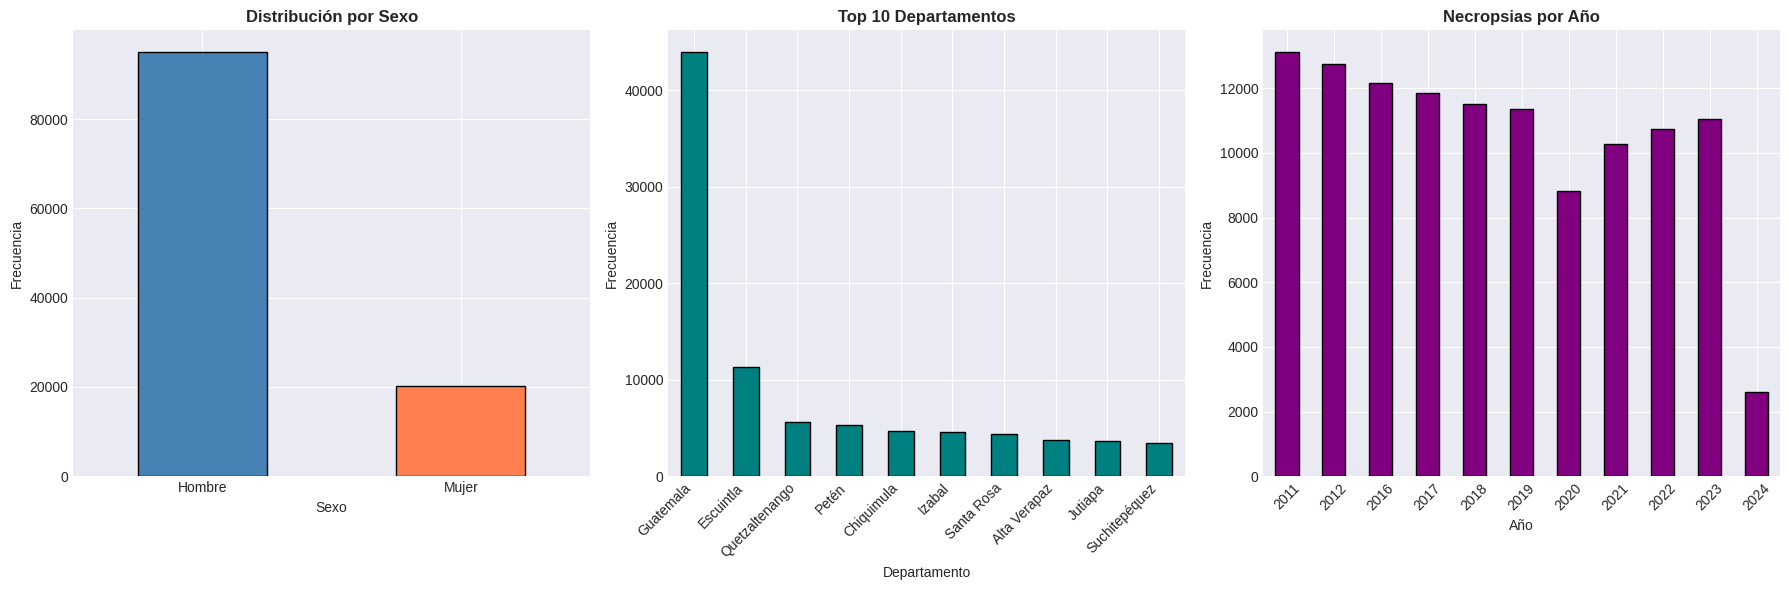

In [14]:
# Gráfico de barras - Distribuciones categóricas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sexo
sexo_freq.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], edgecolor='black')
axes[0].set_title('Distribución por Sexo', fontweight='bold')
axes[0].set_xlabel('Sexo')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=0)

# Top 10 Departamentos
depto_freq.head(10).plot(kind='bar', ax=axes[1], color='teal', edgecolor='black')
axes[1].set_title('Top 10 Departamentos', fontweight='bold')
axes[1].set_xlabel('Departamento')
axes[1].set_ylabel('Frecuencia')
axes[1].tick_params(axis='x', rotation=45)
plt.setp(axes[1].xaxis.get_majorticklabels(), ha='right')

# Necropsias por año
anio_freq = df_limpio['anio'].value_counts().sort_index()
anio_freq.plot(kind='bar', ax=axes[2], color='purple', edgecolor='black')
axes[2].set_title('Necropsias por Año', fontweight='bold')
axes[2].set_xlabel('Año')
axes[2].set_ylabel('Frecuencia')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('graficos/variables_categoricas.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. ANÁLISIS DE CORRELACIONES

7. ANÁLISIS DE CORRELACIONES

Matriz de correlación:
               anio    mes  dia_semana  departamento   edad  causa
anio          1.000  0.010      -0.002         0.010  0.015 -0.021
mes           0.010  1.000       0.011        -0.000  0.011  0.005
dia_semana   -0.002  0.011       1.000        -0.011 -0.026  0.027
departamento  0.010 -0.000      -0.011         1.000  0.009 -0.065
edad          0.015  0.011      -0.026         0.009  1.000  0.101
causa        -0.021  0.005       0.027        -0.065  0.101  1.000


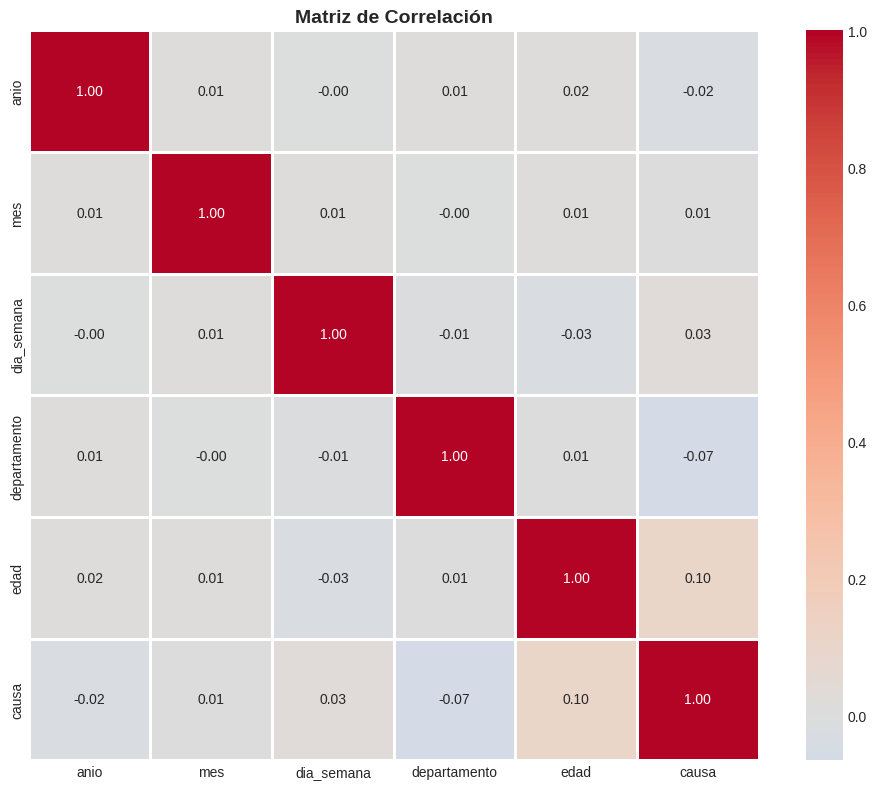

In [15]:
print("="*80)
print("7. ANÁLISIS DE CORRELACIONES")
print("="*80)

# Seleccionar variables numéricas para correlación
vars_corr = ['anio', 'mes', 'dia_semana', 'departamento', 'edad', 'causa']
df_corr = df_limpio[vars_corr].dropna()

correlaciones = df_corr.corr()
print("\nMatriz de correlación:")
print(correlaciones.round(3))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Matriz de Correlación', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graficos/matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

correlaciones.to_csv('resultados/matriz_correlacion.csv')
# =============================================================================
# ANÁLISIS EXPLORATORIO - PARTE 2: PREGUNTAS DE INVESTIGACIÓN Y CLUSTERING
# Universidad del Valle de Guatemala - CC3074 Minería de Datos
# =============================================================================